Enter image filename: pond.jpg
Image loaded: pond.jpg


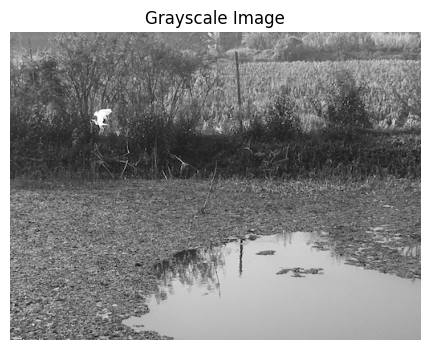

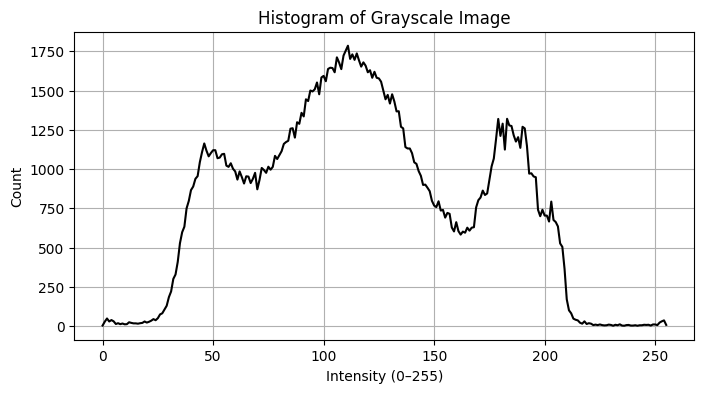

Segmented image saved as: pond_MeanShift_segmented.jpg
Connected components: 2211
Boundary saved: pond_MeanShift_boundary.jpg


In [ ]:
# ============================================================
# GROUP C — FULL PIPELINE 
# ============================================================

import numpy as np
import cv2
import matplotlib.pyplot as plt

# ============================================================
# STEP 1: Read color image
# ============================================================

filename = input("Enter image filename: ")

img_color = cv2.imread(filename)
if img_color is None:
    raise FileNotFoundError(f"Could not read '{filename}'")

print("Image loaded:", filename)


# ============================================================
# STEP 2: Convert to grayscale
# ============================================================

gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6,4))
plt.imshow(gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")
plt.show()


# ============================================================
# STEP 3: Draw histogram
# ============================================================

hist, _ = np.histogram(gray, bins=256, range=(0,256))

plt.figure(figsize=(8,4))
plt.plot(hist, color='black')
plt.title("Histogram of Grayscale Image")
plt.xlabel("Intensity (0–255)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


# ============================================================
# SUPPORT FUNCTIONS FOR MEAN-SHIFT
# ============================================================

def epanechnikov_kernel(u):
    return np.maximum(0.0, 1.0 - u*u)

def mean_shift_histogram(hist, h=40, eps=0.01, max_iter=50):
    x = np.arange(256)
    modes = np.zeros_like(x, dtype=float)
    nonzero = np.where(hist > 0)[0]

    for s in nonzero:
        y = float(s)
        for _ in range(max_iter):
            lo = max(0, int(y - h))
            hi = min(255, int(y + h))

            xs = x[lo:hi+1]
            hs = hist[lo:hi+1]
            if hs.sum() == 0:
                break

            u = (xs - y) / h
            w = epanechnikov_kernel(u) * hs

            if w.sum() == 0:
                break

            y_new = (xs * w).sum() / w.sum()

            if abs(y_new - y) < eps:
                break

            y = y_new

        modes[s] = y

    nz = np.where(hist > 0)[0]
    for i in range(256):
        if hist[i] == 0:
            nearest = nz[np.argmin(np.abs(nz - i))]
            modes[i] = modes[nearest]

    return modes

def enforce_monotonicity(modes):
    m = modes.copy()
    for i in range(1,256):
        if m[i] < m[i-1]:
            m[i] = m[i-1]
    return m

def prune_modes(modes, hist, support_thresh=0.02, gap_thresh=15):
    x = np.arange(256)
    total = hist.sum()
    q = np.round(modes, 2)

    groups = []
    start = 0
    for i in range(1,256):
        if abs(q[i] - q[i-1]) > 1e-2:
            groups.append((start, i-1)); start = i
    groups.append((start,255))

    modes_list = []
    for a,b in groups:
        w = hist[a:b+1].sum()
        if w == 0: continue
        center = (x[a:b+1] * hist[a:b+1]).sum() / w
        modes_list.append((center,a,b,w))

    modes_list.sort(key=lambda z: z[0])

    merged = []
    for m in modes_list:
        if not merged:
            merged.append(m)
        else:
            prev = merged[-1]
            if abs(prev[0] - m[0]) < gap_thresh:
                W = prev[3] + m[3]
                C = (prev[0]*prev[3] + m[0]*m[3]) / W
                merged[-1] = (C, prev[1], m[2], W)
            else:
                merged.append(m)

    pruned = []
    for (c,a,b,w) in merged:
        if w/total >= support_thresh:
            pruned.append(c)

    return np.array(pruned)

def build_lut_from_full_modes(modes_full, pruned_modes):
    lut = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        nearest = pruned_modes[np.argmin(np.abs(pruned_modes - modes_full[i]))]
        lut[i] = int(round(nearest))
    return lut


# ============================================================
# STEP 4: Histogram Mean-Shift Segmentation
# ============================================================

modes = mean_shift_histogram(hist, h=40)
modes = enforce_monotonicity(modes)
final_modes = prune_modes(modes, hist)

lut = build_lut_from_full_modes(modes, final_modes)
segmented = lut[gray]

seg_name = filename.split('.')[0] + "_MeanShift_segmented.jpg"
cv2.imwrite(seg_name, segmented)
print("Segmented image saved as:", seg_name)


# ============================================================
# STEP 5: Connected Components + Boundary Extraction (correct)
# ============================================================

# Convert segmented grayscale → unique labels 0..K-1
unique_vals = np.unique(segmented)
label_map = np.zeros_like(segmented, dtype=np.int32)

for idx, val in enumerate(unique_vals):
    label_map[segmented == val] = idx

num_labels, labels = cv2.connectedComponents(label_map.astype(np.uint8))
print("Connected components:", num_labels)

# Boundary extraction
h, w = labels.shape
boundary = np.zeros((h,w), dtype=np.uint8)

for i in range(1,h-1):
    for j in range(1,w-1):
        if (
            labels[i,j] != labels[i-1,j] or
            labels[i,j] != labels[i+1,j] or
            labels[i,j] != labels[i,j-1] or
            labels[i,j] != labels[i,j+1]
        ):
            boundary[i,j] = 255

boundary_name = filename.split('.')[0] + "_MeanShift_boundary.jpg"
cv2.imwrite(boundary_name, boundary)
print("Boundary saved:", boundary_name)
